## CV Job Matching using Doc2Vec

### Implementation

To implement CV Job Matching using Doc2Vec, we start by importing the necessary libraries and loading the job data from a CSV file. We preprocess the data, keeping only the relevant columns, and merge them into a new column called 'data.' Then, we tokenize the words in the 'data' column and tag them with unique identifiers using the TaggedDocument class.

Next, we initialize the Doc2Vec model with specific parameters, such as the vector size, minimum count, and number of epochs. We build the vocabulary by feeding the tagged data to the model, and then train the model on the tagged data.

After training, we save the model for future use. To match a resume with a job description, we load the saved model and preprocess the resume and job description text. We convert them to lowercase, remove punctuation and numerical values.

Using the trained model, we infer the document vectors for the resume and job description. Then, we calculate the cosine similarity between the two vectors to determine the match between the resume and the job description. The cosine similarity score ranges from -1 to 1, with 1 indicating a perfect match and -1 indicating no similarity.

By employing Doc2Vec and cosine similarity, this approach enables efficient and effective matching between job descriptions and resumes, helping to streamline the job application process and enhance the chances of finding the right candidates for specific positions.

Finally, we also employ a Gauge chart from Plotly to show the matching percentage with threshold that users could consider modifying thier CV to pass Application Tracking System (TSA) from the majority of employers.

### Coding
#### 1. Set up

In [1]:
## Install all dependencies
# !pip install gensim
# !pip install nltk
# !pip install pandas
# !pip install numpy
# !pip install requests
# !pip install PyPDF2
# !pip install termcolor
# !pip install python-docx
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [36]:
# Import libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from numpy.linalg import norm
from termcolor import colored
from docx import Document
import pandas as pd
import numpy as np
import requests
import PyPDF2
import re
import plotly.graph_objects as go
import os
import random
import nltk
import spacy
import json
from spacy.matcher import Matcher
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/hh1980/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### 2. Prepare data
Prepare data from dataset

In [3]:
# Load data
df = pd.read_csv('./dataset/DataScientist.csv')
# Check data
df.head()

,Unnamed: 0,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper\n3.5,"New York, NY","Montreal, Canada",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable,-1,-1
1,1,1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...",4.5,Noom US\n4.5,"New York, NY","New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,Unknown / Non-Applicable,-1,-1
2,2,2,Data Science Manager,$111K-$181K (Glassdoor est.),Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,-1.0,Decode_M,"New York, NY","New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1,True
3,3,3,Data Analyst,$111K-$181K (Glassdoor est.),Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital\n3.4,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,2019,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,"Zocdoc, Healthgrades",-1
4,4,4,"Director, Data Science",$111K-$181K (Glassdoor est.),"Director, Data Science - (200537)\nDescription...",3.4,United Entertainment Group\n3.4,"New York, NY","New York, NY",51 to 200 employees,2007,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"BBDO, Grey Group, Droga5",-1


Since head() fuction does not show all data, we check column names to retain only necessary variables.

In [4]:
# Show column name
df.columns

Index(['Unnamed: 0', 'index', 'Job Title', 'Salary Estimate',
       'Job Description', 'Rating', 'Company Name', 'Location', 'Headquarters',
       'Size', 'Founded', 'Type of ownership', 'Industry', 'Sector', 'Revenue',
       'Competitors', 'Easy Apply'],
      dtype='object')

Keep only some columns to train the model

In [5]:
df =df[['Job Title', 'Job Description', 'Industry', 'Sector']]
df.head()

,Job Title,Job Description,Industry,Sector
0,Senior Data Scientist,"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",Travel Agencies,Travel & Tourism
1,"Data Scientist, Product Analytics","At Noom, we use scientifically proven methods ...","Health, Beauty, & Fitness",Consumer Services
2,Data Science Manager,Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,-1,-1
3,Data Analyst,Sapphire Digital seeks a dynamic and driven mi...,Internet,Information Technology
4,"Director, Data Science","Director, Data Science - (200537)\nDescription...",Advertising & Marketing,Business Services


In [6]:
job_title = df['Job Title'].value_counts().reset_index()
job_title

,index,Job Title
0,Data Scientist,274
1,Data Engineer,260
2,Data Analyst,246
3,Senior Data Scientist,91
4,Senior Data Analyst,47
...,...,...
2074,Phoenix Data Science Tutor Jobs,1
2075,Civil Engineer/GIS Data Analyst,1
2076,Principal Device Modeling Engineer,1
2077,SQL/SAS Data Analyst,1


In [7]:
# Create a new column called 'data' and merge the values of the other columns into it
df['data'] = df[['Job Title', 'Job Description', 'Industry', 'Sector']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
# Drop the individual columns if you no longer need them
df.drop(['Job Title', 'Job Description', 'Industry', 'Sector'], axis=1, inplace=True)
# Preview the updated dataframe
print(df.head())

                                                data
0  Senior Data Scientist ABOUT HOPPER\n\nAt Hoppe...
1  Data Scientist, Product Analytics At Noom, we ...
2  Data Science Manager Decode_M\n\nhttps://www.d...
3  Data Analyst Sapphire Digital seeks a dynamic ...
4  Director, Data Science Director, Data Science ...


#### 3. Tokenize data
We tokenize the words in the 'data' column and tag them with unique identifiers using the TaggedDocument class.

In [8]:
# Tag data
data = list(df['data'])
tagged_data = [TaggedDocument(words = word_tokenize(_d.lower()), tags = [str(i)]) for i, _d in enumerate(data)]

#### 4. Model initialization and vocabulary buiding
Next, we initialize the Doc2Vec model with specific parameters.

**Parameters** of Doc2Vec are as follows: 

- `vector_size`: Dimensionality of the feature vectors. Default: 100.
- `window`: The window refers to the maximum distance between the target word and its context words within a sentence. Default: 5.
- `min_count`: Ignores all words with a total frequency lower than this. Default: 5.
- `epochs`: Number of iterations (epochs) over the corpus. Defaults to 5 for PV-DBOW and 10 for PV-DM.
- `dm`: Defines the training algorithm. If `dm = 1`, the Distributed Memory (PV-DM) model is used. If `dm = 0`, the Distributed Bag of Words (PV-DBOW) model is used. Default: 1 (PV-DM).
- `dbow_words`: If set to 1, trains word vectors (in addition to document vectors) using the PV-DBOW algorithm. Default: 0 (False).
- `dm_mean`: If set to 1, uses the mean of the context word vectors instead of concatenation when inferring vectors in the PV-DM model. Default: 0 (False).
- `dm_concat`: If set to 1, concatenates the document and context word vectors when inferring vectors in the PV-DM model. Default: 0 (False).
- `dm_tag_count`: Expected number of document tags per document, when using the PV-DM algorithm. Default: 1.
- `dbow_tag_count`: Expected number of document tags per document, when using the PV-DBOW algorithm. Default: 1.
- `alpha`: The initial learning rate. Default: 0.025.
- `min_alpha`: The learning rate will linearly drop to `min_alpha` as training progresses. Default: 0.0001.
- `hs`: If set to 1, hierarchical softmax activation function will be used. Default: 0 (Negative Sampling).
- `negative`: If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drawn. Default: 5.
- `ns_exponent`: The exponent used to shape the negative sampling distribution. Default: 0.75.


In [9]:
# Model initialization
model = Doc2Vec(vector_size = 50,
min_count = 5,
epochs = 10,
alpha = 0.001
)

In [10]:
# Vocabulary building
model.build_vocab(tagged_data)
# Get the vocabulary keys
keys = model.wv.key_to_index.keys()
# Print the length of the vocabulary keys
print(len(keys))

11885


#### 5. Train and save the model
Train the model on tagged data.

In [11]:
# Train the model
for epoch in range(model.epochs):
    print(f"Training epoch {epoch+1}/{model.epochs}")
    model.train(tagged_data, 
                total_examples=model.corpus_count, 
                epochs=model.epochs)

model.save('cv_job_maching.model')
print("Model saved")

Training epoch 1/10
Training epoch 2/10
Training epoch 3/10
Training epoch 4/10
Training epoch 5/10
Training epoch 6/10
Training epoch 7/10
Training epoch 8/10
Training epoch 9/10
Training epoch 10/10
Model saved


#### 6. Create perfect resumes for validation

In [15]:
# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

# Extract Job Requirements
def extract_requirements(job_description):
    # Use spaCy to extract skills, experience, and education
    doc = nlp(job_description)
    skills = extract_skills(doc)
    experience = extract_experience(doc)
    education = extract_education(doc)

    return {
        'skills': skills,
        'experience': experience,
        'education': education
    }

def extract_skills(doc):
    # Define patterns to match skills
    skill_patterns = [
        [{'POS': 'NOUN'}, {'LOWER': 'skills'}],
        [{'POS': 'NOUN'}, {'LOWER': 'experience'}, {'LOWER': 'in'}]
    ]
    matcher = Matcher(nlp.vocab)
    matcher.add("SKILLS", skill_patterns)

    skills = []
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        skills.append(span.text)

    return skills

def extract_experience(doc):
    # Define patterns to match experience requirements
    exp_patterns = [
        [{'LOWER': 'experience'}, {'POS': 'NUM'}, {'LOWER': 'years'}],
        [{'LOWER': 'minimum'}, {'POS': 'NUM'}, {'LOWER': 'years'}, {'LOWER': 'experience'}]
    ]
    matcher = Matcher(nlp.vocab)
    matcher.add("EXPERIENCE", exp_patterns)

    experience = []
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        experience.append(span.text)

    return experience

def extract_education(doc):
    # Define patterns to match education requirements
    edu_patterns = [
        [{'LOWER': 'degree'}, {'POS': 'NOUN'}],
        [{'LOWER': 'bachelor'}, {'POS': 'NOUN'}],
        [{'LOWER': 'master'}, {'POS': 'NOUN'}]
    ]
    matcher = Matcher(nlp.vocab)
    matcher.add("EDUCATION", edu_patterns)

    education = []
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        education.append(span.text)

    return education

In [16]:
# Fill the Resume Template
def fill_resume_template(job_description, template):
    # Extract requirements from job description
    requirements = extract_requirements(job_description)

    # Fill the template with the requirements
    resume = template.copy()
    resume['Skills'] = ', '.join(requirements['skills'])
    resume['Work Experience'] = [create_work_experience(req, requirements['skills']) for req in requirements['experience']]
    resume['Education'] = create_education(requirements['education'][0]) if requirements['education'] else None

    # Add relevant sections for data science roles
    resume['Programming Languages'] = ', '.join(get_programming_languages(requirements['skills']))
    resume['Data Science Skills'] = ', '.join(get_data_science_skills(requirements['skills']))
    resume['Tools & Technologies'] = ', '.join(get_tools_and_technologies(requirements['skills']))

    # Differentiate resumes based on specific requirements
    resume['Domain Expertise'] = ', '.join(get_domain_expertise(job_description))
    resume['Specialized Skills'] = ', '.join(get_specialized_skills(job_description))

    return resume

def create_work_experience(experience_requirement, skills):
    # Parse the experience requirement
    match = re.search(r'(\d+)\s*years', experience_requirement, re.I)
    if match:
        years = int(match.group(1))
        position = 'Data Scientist' if 'data scientist' in experience_requirement.lower() else 'Relevant Position'
        return {
            'Position': position,
            'Company': 'Relevant Company',
            'Duration': f'{years} years',
            'Responsibilities': ', '.join(skills)
        }
    return None

def create_education(education_requirement):
    # Parse the education requirement
    degree_match = re.search(r'(bachelor|master|phd)\s*(degree|\'s)', education_requirement, re.I)
    if degree_match:
        degree_type = degree_match.group(1).capitalize()
        return {
            'Degree': f'{degree_type} Degree',
            'Field': 'Data Science, Statistics, Computer Science, or related field',
            'University': 'Relevant University'
        }
    return None

def get_programming_languages(skills):
    languages = ['Python', 'R', 'SQL', 'Java', 'C++', 'C', 'Scala']
    return [lang for lang in languages if lang.lower() in [skill.lower() for skill in skills]]

def get_data_science_skills(skills):
    data_science_skills = ['Machine Learning', 'Statistical Modeling', 'Data Analysis', 'Data Visualization',
                           'Deep Learning', 'Natural Language Processing', 'Computer Vision', 'Reinforcement Learning']
    return [skill for skill in data_science_skills if any(s.lower() in skill.lower() for s in skills)]

def get_tools_and_technologies(skills):
    tools_and_technologies = ['Pandas', 'NumPy', 'Scikit-learn', 'TensorFlow', 'Spark', 'Hadoop', 'Hive', 'Impala',
                              'MapReduce', 'Pig', 'MongoDB', 'Postgres', 'NoSQL', 'Beautifulsoup', 'Selenium', 'Scrapy',
                              'HTML5', 'JavaScript', 'CSS', 'R Shiny', 'Tableau']
    return [tool for tool in tools_and_technologies if any(s.lower() in tool.lower() for s in skills)]

def get_domain_expertise(job_description):
    domains = ['Healthcare', 'Finance', 'Retail', 'Marketing', 'Telecommunications', 'Manufacturing', 'Energy',
               'Transportation', 'Government', 'Defense', 'Security']
    return [domain for domain in domains if domain.lower() in job_description.lower()]

def get_specialized_skills(job_description):
    specialized_skills = ['Recommender Systems', 'Natural Language Processing', 'Computer Vision', 'Time Series Analysis',
                          'Forecasting', 'Clustering', 'Ensemble Methods', 'Bayesian Methods', 'Neural Networks',
                          'Deep Learning', 'Reinforcement Learning', 'Collaborative Filtering', 'Web Scraping']
    return [skill for skill in specialized_skills if any(s.lower() in job_description.lower() for s in skill.split())]


In [18]:
# Create a Resume Template
resume_template = {
    'Personal Information': {
        'Name': '',
    },
    'Skills': '',
    'Work Experience': [],
    'Education': {},
}

In [19]:
# Generate Perfect Resumes
perfect_resumes = []
for job_description in df['data']:
    perfect_resume = fill_resume_template(job_description, resume_template)
    perfect_resumes.append(perfect_resume)

#### 7. Inputs of CV and JD

- **Resume**:

Get a random resume from our resume dataset

In [25]:
# Get a list of all .docx resume files
resumes = [f for f in os.listdir('./dataset/resumes') if f.endswith('.docx')]

# Select a random .docx file
random_resume = random.choice(resumes)

# Create a Document object
doc = Document(os.path.join('./dataset/resumes', random_resume))

# Extract text
resume = ""
for para in doc.paragraphs:
    resume += para.text
    
print(resume)

Kashyap K. VoraPhone: 201-532-6397. Email: kashyapkvora@gmail.com__________________________________________________________________________________________________Professional SummaryOverall 10 years of experience as Sr. Technical Business System Analyst (Technical BSA) in Information Technology industry with focus on Data Analysis, Information & Data Management, Service-Oriented Architecture (SOA), Data Mapping & Data Modeling, Business Process Improvement, System Analysis & Design; expertise in implementation of IT projects using Project Management methodologies. Extensive experience in diversified industry sectors including Healthcare, Life Insurance, Personal & Commercial Insurance, Property & Casualty Insurance, Telecommunication, Retail & e-Commerce (Web Merchandising), Commercial & Investment Banking and Credit Card services.Strong skills in Data Warehouse Design using Star Schema roll out for the fact and dimension tables. Design of cubes, partitions and aggregations with excel

- **Job Description**:

Get a random JD from dataset

In [26]:
# Select a random JD from the dataset
random_jd = random.choice(df['data'])

print("Random JD:", random_jd)

Random JD: Senior Data Scientist - Nationwide Opportunities Want to help the largest global enterprises derive business value through the adoption of Artificial Intelligence (AI) and Machine Learning (ML)? Excited by using massive amounts of disparate data to develop ML models? Eager to learn to apply ML to a diverse array of enterprise use cases? Thrilled to be a part of Amazon who has been pioneering and shaping the worlds AI/ML technology for decades?


At Amazon Web Services (AWS), we are helping large enterprises build ML models on the AWS Cloud. We are applying predictive technology to large volumes of data and against a wide spectrum of problems. AWS Professional Services works together with AWS customers to address their business needs using AI solutions.

AWS Professional Services is a unique consulting team. We pride ourselves on being customer obsessed and highly focused on the AI enablement of our customers. If you have experience with AI, including building ML models, wed 

In [27]:
# Find the corresponding perfect resume for the random JD
perfect_resume = perfect_resumes[df['data'].tolist().index(random_jd)]

Input JD Input in text below

In [18]:
# # JD by input text:
# jd = input("Paste your JD here: ")

Paste your JD here:  DoITT provides for the sustained, efficient and effective delivery of IT services, infrastructure and telecommunications to enhance service delivery to New York City's residents, businesses, employees and visitors. As the City's technology leader, DoITT is responsible for maintaining the foundational IT infrastructure and systems that touch every aspect of City life from public safety to human services, from education to economic development crossing the full spectrum of governmental operations.    The CSCL database is a centralized database under the Emergency Communications Transformation Program (ECTP) intended to support the emergency response agencies as well as all other City agencies. This database is unique in its complexity and contains over 100 feature classes and tables, among which are represented all streets, addresses, transit infrastructure, schools and other public and private facilities.    The successful candidate will serve as a GIS Analyst repor

In [15]:
# jd = """
# Proactively engage with clients in the branch and deliver an outstanding service experience through completing transactions and by identifying opportunities for advice, solutions, digital enablement and partner introductions
# Focus on education and demonstration, leverage technology to deliver a memorable client experience, drive solutions and retain business
# Contribute to team results by listening and spotting opportunities to offer additional advice, introduce clients to the capability of RBC partners, or personally fulfil client solutions
# Proactively take ownership of resolving and preventing client banking problems
# Cultivate and maintain relationships with partners to work as one RBC team
# Manage risks by adhering to compliance routines, processes, and controls to protect client and shareholder interests while completing transactions
# What do you need to succeed?

# Must-have

# Goal-oriented individual with a demonstrated passion for putting clients first.
# Drive and self-motivation, as well as excellent communication skills and emotional intelligence
# Digital literacy across a broad range of devices (i.e., smartphones, tablets, laptops, etc.)
# Personal flexibility to work flex hours
# Eagerness to learn and determination to succeed
# Confidence and ability to learn financial concepts and willingness to obtain the Investment Funds in Canada or the Canadian Securities Course
# Nice-to-have

# Track record in building rapport and maintaining client relationships within the financial, service or retail industry
# Mutual Funds accreditation
# Is this job right for you? Check out our video and decide for yourself!

# What’s in it for you?

# We thrive on the challenge to be our best, progressive thinking to keep growing, and working together to deliver trusted advice to help our clients thrive and communities prosper. We care about each other, reaching our potential, making a difference to our communities, and achieving success that is mutual.

# A comprehensive Total Rewards Program including bonuses and flexible benefits, competitive compensation, commissions, and stock where applicable
# A world-class training program in financial services
# Excellent career development and access to a variety of job opportunities across business and geographies
# Leaders who support your development through coaching and managing opportunities
# Work in a dynamic, collaborative, progressive, and high-performing team
# We also strive to provide an accessible candidate experience for our prospective employees with different abilities. Please let us know if you need any accommodations during the recruitment process.

# Join our Talent Community

# Stay in-the-know about great career opportunities at RBC. Sign up and get customized info on our latest jobs, career tips and Recruitment events that matter to you.

# Expand your limits and create a new future together at RBC. Find out how we use our passion and drive to enhance the well-being of our clients and communities at rbc.com/careers.
# """

- **Develop a function to pre-process input text**:

In [28]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub('http\S+\s*', ' ', text)

    # Remove RT and cc
    text = re.sub('RT|cc', ' ', text)

    # Remove hashtags
    text = re.sub('#\S+', '', text)

    # Remove mentions
    text = re.sub('@\S+', '  ', text)
    
    # Convert the text to lowercase
    text = text.lower()
    
    # Remove punctuation from the text
    text = re.sub('[^a-z]', ' ', text)
    
    # Remove numerical values from the text
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespaces
    text = ' '.join(text.split())
    
    return text

In [37]:
# Convert the perfect_resume dictionary to a string
perfect_resume_str = json.dumps(perfect_resume)

# Apply preprocess function to CV, JD, and perfect resume
input_CV = preprocess_text(resume)
input_JD = preprocess_text(random_jd)
perfect_resume_text = preprocess_text(perfect_resume_str)

#### 8. Matching
Using the trained model, we infer the document vectors for the resume and job description. Then, we calculate the cosine similarity between the two vectors to determine the match between the resume and the job description.

In [40]:
# Function to calculate cosine similarity
def calculate_similarity(vector1, vector2):
    return cosine_similarity([vector1], [vector2])[0][0]

# Infer vectors for the random resume, random JD, and perfect resume
random_resume_vector = model.infer_vector(word_tokenize(input_CV))
random_jd_vector = model.infer_vector(word_tokenize(input_JD))
perfect_resume_vector = model.infer_vector(word_tokenize(perfect_resume_text))

# Calculate similarity scores
random_resume_similarity = calculate_similarity(random_resume_vector, random_jd_vector)
perfect_resume_similarity = calculate_similarity(perfect_resume_vector, random_jd_vector)


In [41]:
#### 9. Visualization

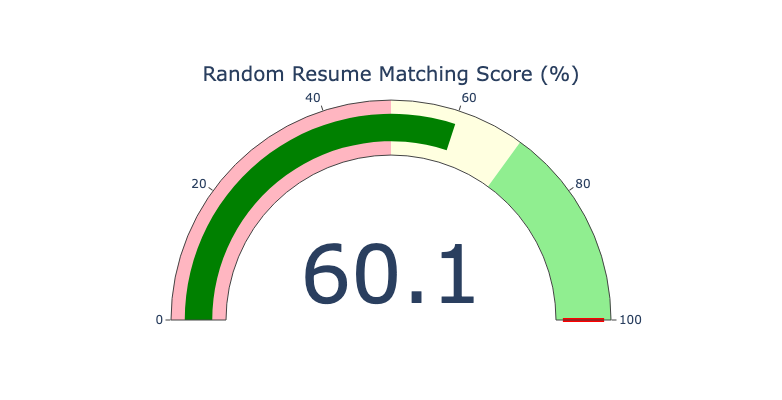

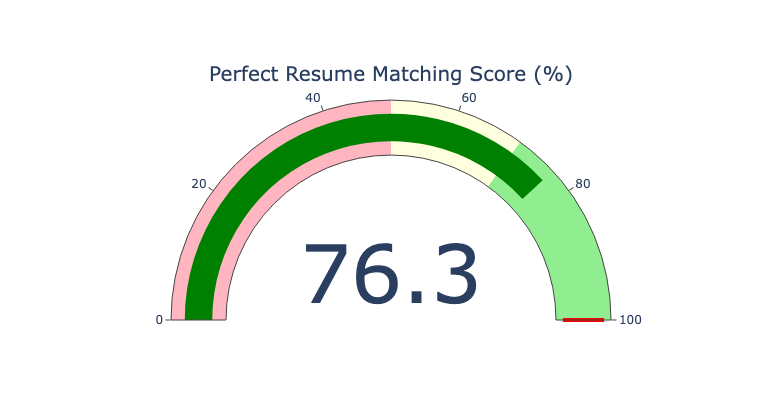


Random Resume Matching Score: 60.083186626434326 %
Perfect Resume Matching Score: 76.30323767662048 %
Good chance but you can improve further!


In [42]:
# Visualization
fig1 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=random_resume_similarity * 100,
    title={'text': "Random Resume Matching Score (%)"},
    gauge={
        'axis': {'range': [0, 100]},
        'steps': [
            {'range': [0, 50], 'color': "#FFB6C1"},
            {'range': [50, 70], 'color': "#FFFFE0"},
            {'range': [70, 100], 'color': "#90EE90"}
        ],
        'threshold': {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 100}
    }
))

fig1.update_layout(width=400, height=400)  # Adjust the width and height as desired
fig1.show()

fig2 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=perfect_resume_similarity * 100,
    title={'text': "Perfect Resume Matching Score (%)"},
    gauge={
        'axis': {'range': [0, 100]},
        'steps': [
            {'range': [0, 50], 'color': "#FFB6C1"},
            {'range': [50, 70], 'color': "#FFFFE0"},
            {'range': [70, 100], 'color': "#90EE90"}
        ],
        'threshold': {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 100}
    }
))

fig2.update_layout(width=400, height=400)  # Adjust the width and height as desired
fig2.show()

# Print results
print("\nRandom Resume Matching Score:", random_resume_similarity * 100, "%")
print("Perfect Resume Matching Score:", perfect_resume_similarity * 100, "%")

if random_resume_similarity < 0.5:
    print(colored("Low chance, need to modify your CV!", "red", attrs=["bold"]))
elif random_resume_similarity >= 0.5 and random_resume_similarity < 0.7:
    print(colored("Good chance but you can improve further!", "yellow", attrs=["bold"]))
else:
    print(colored("Excellent! You can submit your CV.", "green", attrs=["bold"]))


In [ ]:
# # Evaluate Model
# def evaluate_model(perfect_resumes, model_predictions):
#     # Assuming model_predictions is a list of tuples (resume, score, rank)
#     true_positives = 0
#     false_positives = 0
#     false_negatives = 0

#     for perfect_resume, (predicted_resume, score, rank) in zip(perfect_resumes, model_predictions):
#         # Define a threshold for considering a resume as a positive match
#         threshold = 0.7  # Adjust this value as needed

#         # Check if the predicted resume matches the perfect resume
#         if score >= threshold:
#             if perfect_resume == predicted_resume:
#                 true_positives += 1
#             else:
#                 false_positives += 1
#         else:
#             if perfect_resume != predicted_resume:
#                 false_negatives += 1

#     precision = precision_score(true_positives, true_positives + false_positives)
#     recall = recall_score(true_positives, true_positives + false_negatives)
#     f1 = f1_score(true_positives, true_positives + false_positives + false_negatives)

#     print(f"Precision: {precision:.2f}")
#     print(f"Recall: {recall:.2f}")
#     print(f"F1-score: {f1:.2f}")

# # Save perfect resumes to a file
# with open('perfect_resumes.txt', 'w', encoding='utf-8') as f:
#     for resume in perfect_resumes:
#         resume_str = str(resume)
#         f.write(resume_str + '\n')

In [ ]:
# # Validation: Compare perfect resumes with random resumes
# random_resumes = [f for f in os.listdir('./dataset/resumes') if f.endswith('.docx')]

# for job_description, perfect_resume in zip(df['data'], perfect_resumes):
#     print(f"\nJob Description: {job_description}")
#     print(f"Perfect Resume: {perfect_resume}")

#     # Get a random resume
#     random_resume_file = random.choice(random_resumes)
#     random_resume_doc = Document(os.path.join('./dataset/resumes', random_resume_file))
#     random_resume_text = ""
#     for para in random_resume_doc.paragraphs:
#         random_resume_text += para.text

#     # Preprocess the job description, perfect resume, and random resume
#     input_JD = preprocess_text(job_description)
#     input_perfect_resume = preprocess_text(str(perfect_resume))
#     input_random_resume = preprocess_text(random_resume_text)

#     # Calculate similarity scores
#     model = Doc2Vec.load('cv_job_maching.model')
#     v1 = model.infer_vector(input_perfect_resume.split())
#     v2 = model.infer_vector(input_JD.split())
#     v3 = model.infer_vector(input_random_resume.split())

#     perfect_resume_score = 100 * (np.dot(np.array(v1), np.array(v2))) / (norm(np.array(v1)) * norm(np.array(v2)))
#     random_resume_score = 100 * (np.dot(np.array(v3), np.array(v2))) / (norm(np.array(v3)) * norm(np.array(v2)))

#     print(f"Perfect Resume Score: {perfect_resume_score:.2f}")
#     print(f"Random Resume Score: {random_resume_score:.2f}")

    
#     # Visualization
#     fig = go.Figure()

#     fig.add_trace(go.Indicator(
#         mode="gauge+number",
#         value=perfect_resume_score,
#         title={'text': "Perfect Resume Score"},
#         gauge={
#             'axis': {'range': [0, 100]},
#             'steps': [
#                 {'range': [0, 50], 'color': "#FFB6C1"},
#                 {'range': [50, 70], 'color': "#FFFFE0"},
#                 {'range': [70, 100], 'color': "#90EE90"}
#             ],
#             'threshold': {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 100}
#         }
#     ))

#     # Print feedback results
# if similarity < 50:
#     print(colored("Low chance, need to modify your CV!", "red", attrs=["bold"]))
# elif similarity >= 50 and similarity < 70:
#     print(colored("Good chance but you can improve further!", "yellow", attrs=["bold"]))
# else:
#     print(colored("Excellent! You can submit your CV.", "green", attrs=["bold"]))

#     fig.add_trace(go.Indicator(
#         mode="gauge+number",
#         value=random_resume_score,
#         title={'text': "Random Resume Score"},
#         gauge={
#             'axis': {'range': [0, 100]},
#             'steps': [
#                 {'range': [0, 50], 'color': "#FFB6C1"},
#                 {'range': [50, 70], 'color': "#FFFFE0"},
#                 {'range': [70, 100], 'color': "#90EE90"}
#             ],
#             'threshold': {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 100}
#         }
#     ))

#     fig.update_layout(width=800, height=400, grid={'rows': 1, 'columns': 2})
#     fig.show()

# # Print feedback results
# if similarity < 50:
#     print(colored("Low chance, need to modify your CV!", "red", attrs=["bold"]))
# elif similarity >= 50 and similarity < 70:
#     print(colored("Good chance but you can improve further!", "yellow", attrs=["bold"]))
# else:
#     print(colored("Excellent! You can submit your CV.", "green", attrs=["bold"]))

In [ ]:
# # Validation: Compare perfect resumes with random resumes
# random_resumes = [f for f in os.listdir('./dataset/resumes') if f.endswith('.docx')]

# for job_description, perfect_resume in zip(df['data'], perfect_resumes):
#     # Get a random resume
#     random_resume_file = random.choice(random_resumes)
#     random_resume_doc = Document(os.path.join('./dataset/resumes', random_resume_file))
#     random_resume_text = ""
#     for para in random_resume_doc.paragraphs:
#         random_resume_text += para.text

#     # Preprocess the job description, perfect resume, and random resume
#     input_JD = preprocess_text(job_description)
#     input_perfect_resume = preprocess_text(str(perfect_resume))
#     input_random_resume = preprocess_text(random_resume_text)

#     # Calculate similarity scores
#     model = Doc2Vec.load('cv_job_maching.model')
#     v1 = model.infer_vector(input_perfect_resume.split())
#     v2 = model.infer_vector(input_JD.split())
#     v3 = model.infer_vector(input_random_resume.split())

#     perfect_resume_score = 100

In [20]:
# # Model evaluation
# model = Doc2Vec.load('cv_job_maching.model')
# v1 = model.infer_vector(input_CV.split())
# v2 = model.infer_vector(input_JD.split())
# similarity = 100*(np.dot(np.array(v1), np.array(v2))) / (norm(np.array(v1)) * norm(np.array(v2)))
# print(round(similarity, 2))

83.36
